# Project: Investigate a Dataset (TMDb Movie Data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
For this project I have chosen to analyse movie data from TMDb ([The Movie Database](https://www.themoviedb.org)) for over 10,000 movies aggregated by [Kaggle](https://www.kaggle.com). The data contains information such as genre, cast, budget, revenue, popularity, rating etc. 

_These are the question I want to explore:_

1. Trends in budget and revenue over the years.
2. What are the characteristics of movies with highest revenues?
    * Budget
    * Popularity
    * Cast
    * Genres
    * Production Companies
    * Director
    * Month and Day of the week of release

### Environment Setup

In [1]:
## import statements
import unicodecsv
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## magics
%matplotlib inline

## initializations
sns.set_style('darkgrid')
tmdb_csv_file = 'tmdb-movies.csv'
plt.rcParams.update({'font.size': 12}) # set font size for plot labels and titles

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Let's take a look at some of the rows in the data:

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

## read csv file:
initial_df = pd.read_csv(tmdb_csv_file)
                         
## print first five rows in data:
initial_df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


Comments:
* The data contains __imdb_id__ as well as __id__ from TMDb. This is may have been provided to correlate data from both databases.
* The __budget__ and __revenue__ columns are not of much use as it will be more appropriate to use the adjusted values, __budget_adj__ and __revenue_adj__ to compare movies from different time periods.
* No units for the budget and revenue are provided. I'll assume them to be dollars.

Now I want to know some basic info about the data:

In [3]:
## describe the table:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

A lot of columns have many null values. I will handle them as and when needed.

In [4]:
## number of rows:
len(initial_df)

10866

In [5]:
## range of years from which movies are included:

release_years = initial_df['release_year']
print(int(release_years.min()),'-',int(release_years.max()))

1960 - 2015


In [6]:
## Highest revenue movie:

# It will be nice to have a function that prints info about a movie with a particular id:

def describe_movie(tmdb_id, df):
    '''
        Displays info about a movie with a particular TMDb ID.
    '''
    # first let's get the row for this id:
    movie_df_intermediate = df[df['id'] == tmdb_id]
    # ^ this is still a dataframe... we need to convert this to a series:
    movie_row = pd.Series(movie_df_intermediate.iloc[0])
    
    # now printing relevant info:
    print('{}({}):'.format(movie_row['original_title'], movie_row[ 'release_year']))
    print('\tBudget (Adjusted): {}$'.format(movie_row['budget_adj']))
    print('\tRevenue (Adjusted): {}$'.format(movie_row['revenue_adj']))
    print('\tDirector: {}'.format(movie_row['director'])) 
    print('\tGenres: {}'.format(', '.join(movie_row['genres'].split('|'))))
    print('\tCast: {}'.format(', '.join(movie_row['cast'].split('|'))))
    print('\tAverage Rating:', movie_row['vote_average'])
    print('\tPopularity:', movie_row['popularity'])
    
    
max_revenue_idx = initial_df['revenue_adj'].idxmax()
max_revenue_tmdb_id = initial_df.loc[max_revenue_idx, 'id']
describe_movie(max_revenue_tmdb_id, initial_df)


Avatar(2009):
	Budget (Adjusted): 240886902.887613$
	Revenue (Adjusted): 2827123750.41189$
	Director: James Cameron
	Genres: Action, Adventure, Fantasy, Science Fiction
	Cast: Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang, Michelle Rodriguez
	Average Rating: 7.1
	Popularity: 9.432768


In [7]:
## Highest budget movie:

max_budget_idx = initial_df['budget_adj'].idxmax()
max_budget_tmdb_id = initial_df.loc[max_budget_idx, 'id']
describe_movie(max_budget_tmdb_id, initial_df)

The Warrior's Way(2010):
	Budget (Adjusted): 425000000.0$
	Revenue (Adjusted): 11087569.0$
	Director: Sngmoo Lee
	Genres: Adventure, Fantasy, Action, Western, Thriller
	Cast: Kate Bosworth, Jang Dong-gun, Geoffrey Rush, Danny Huston, Ti Lung
	Average Rating: 6.4
	Popularity: 0.25054


In [8]:
## Highest rated movie:

max_rating_idx = initial_df['vote_average'].idxmax()
max_rating_tmdb_id = initial_df.loc[max_rating_idx, 'id']
describe_movie(max_rating_tmdb_id, initial_df)

The Story of Film: An Odyssey(2011):
	Budget (Adjusted): 0.0$
	Revenue (Adjusted): 0.0$
	Director: Mark Cousins
	Genres: Documentary
	Cast: Mark Cousins, Jean-Michel Frodon, Cari Beauchamp, Agnes de Mille
	Average Rating: 9.2
	Popularity: 0.006925


The budget and revenue data for this movie seems to be unavailable.

In [9]:
## Most popular movie:

max_popularity_idx = initial_df['popularity'].idxmax()
max_popularity_tmdb_id = initial_df.loc[max_popularity_idx, 'id']
describe_movie(max_popularity_tmdb_id, initial_df)

Jurassic World(2015):
	Budget (Adjusted): 137999939.280026$
	Revenue (Adjusted): 1392445892.5238$
	Director: Colin Trevorrow
	Genres: Action, Adventure, Science Fiction, Thriller
	Cast: Chris Pratt, Bryce Dallas Howard, Irrfan Khan, Vincent D'Onofrio, Nick Robinson
	Average Rating: 6.5
	Popularity: 32.985763


### Problems With Dataset
While inspecting the data, I noticed the following problems which need to be addressed:
* The __budget_adj__ and __revenue_adj__ columns have 0 value in many rows.
* The __budget__ and __revenue__ columns are unadjusted and thus not useful for the analysis. Also, the __imdb_id__ column is redundant as I will use the TMDb IDs. These columns should be removed.
* The __release_date__ column is stored as a string. The dates need to be converted to datetime objects.
* The columns __production_companies__, __cast__ and __genres__ should be converted to list/tuples for convenience.

Let's check for duplicate rows in the data:

In [10]:
# select rows which have been duplicated:
initial_df[initial_df.duplicated() == True]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2090,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0


Only one row has been duplicated. I will clean this up in the next section.

### Data Cleaning

#### Removing useless columns
First I'll remove the following columns as I do not need them in my analysis:
* budget
* revenue
* imdb_id
* homepage
* overview
* tagline
* vote count
* keywords

In [11]:
# using drop() function to drop useless columns:

useless_columns = ['budget', 'revenue', 'imdb_id', 'homepage', 'overview', 'tagline', 'vote_count', 'keywords']
cleaned_df = initial_df.drop(useless_columns, axis=1) # axis = 1 means columns (0 for rows)

cleaned_df.head(2)

,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,7.1,2015,1.379999e+08,3.481613e+08


#### Removing the duplicate rows

In [12]:
# drop_duplicates() drops all duplicate rows
cleaned_df.drop_duplicates(inplace=True)

#### Handling null values
Let's replace 0s in budget and revenue columns with NaNs:

In [13]:
# replacing values 0s with NaNs:
cleaned_df.loc[cleaned_df['revenue_adj'] == 0, 'revenue_adj'] = np.nan
cleaned_df.loc[cleaned_df['budget_adj'] == 0, 'budget_adj'] = np.nan

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 13 columns):
id                      10865 non-null int64
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              5169 non-null float64
revenue_adj             4849 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.2+ MB


The non-null counts for __budget_adj__ and __revenue_adj__ have been reduced by almost half!

#### Correcting Data Types

First, let's convert __release_year__ column to datetime objects:

In [14]:
# I will use the to_datetime function provied in pandas:
cleaned_df['release_date'] = pd.to_datetime(cleaned_df['release_date'])

# checking:
cleaned_df.loc[100, 'release_date'].year

2015

Now converting __production_companies__, __cast__ and __genres__ to lists:

In [15]:
def string_to_list(string):
    '''
        Returns a list of strings obtained by splitting the input string.
        If input is not a string, returns NaN.
    '''
    if isinstance(string, str):
        return string.split('|')
    return np.nan

cleaned_df['genres'] = cleaned_df['genres'].apply(string_to_list)
cleaned_df['production_companies'] = cleaned_df['production_companies'].apply(string_to_list)
cleaned_df['cast'] = cleaned_df['cast'].apply(string_to_list)

# checking:
cleaned_df.head(2)

,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",2015-06-09,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",George Miller,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",2015-05-13,7.1,2015,1.379999e+08,3.481613e+08


#### More considerations

For both of my questions, I need both the revenue and budget data available. Many rows are missing one or both of these values. I will drop rows that are missing budget or revenue information.

In [16]:
# create dataset for second question about high-revenue movies
# drop rows without budget or revenue information:

revenue_df = cleaned_df.dropna(subset=['revenue_adj', 'budget_adj'], how='any')
print('Movies with both revenue and budget info:', len(revenue_df))
revenue_df.head()

Movies with both revenue and budget info: 3854


,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",2015-06-09,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",George Miller,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",2015-05-13,7.1,2015,1.379999e+08,3.481613e+08
2,262500,13.112507,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",Robert Schwentke,119,"[Adventure, Science Fiction, Thriller]","[Summit Entertainment, Mandeville Films, Red W...",2015-03-18,6.3,2015,1.012000e+08,2.716190e+08
3,140607,11.173104,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",J.J. Abrams,136,"[Action, Adventure, Science Fiction, Fantasy]","[Lucasfilm, Truenorth Productions, Bad Robot]",2015-12-15,7.5,2015,1.839999e+08,1.902723e+09
4,168259,9.335014,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",James Wan,137,"[Action, Crime, Thriller]","[Universal Pictures, Original Film, Media Righ...",2015-04-01,7.3,2015,1.747999e+08,1.385749e+09


The size of the dataset has been decreased quite a bit. But it should still be sufficient for my analysis. The dropped rows might have been useful for some other questions, but my research questions require them to be dropped.

<a id='eda'></a>
## Exploratory Data Analysis

### Trends In Budgets And Revenues

#### Statistics

In [17]:
## budget statistics (adjusted):

budgets_adj = revenue_df['budget_adj']
budgets_adj.describe()

count    3.854000e+03
mean     4.423999e+07
std      4.480925e+07
min      9.693980e-01
25%      1.309053e+07
50%      3.001611e+07
75%      6.061307e+07
max      4.250000e+08
Name: budget_adj, dtype: float64

In [18]:
## revenue statistics (adjusted):

revenues_adj = revenue_df['revenue_adj']
revenues_adj.describe()

count    3.854000e+03
mean     1.370647e+08
std      2.161114e+08
min      2.370705e+00
25%      1.835735e+07
50%      6.173068e+07
75%      1.632577e+08
max      2.827124e+09
Name: revenue_adj, dtype: float64

#### Plots

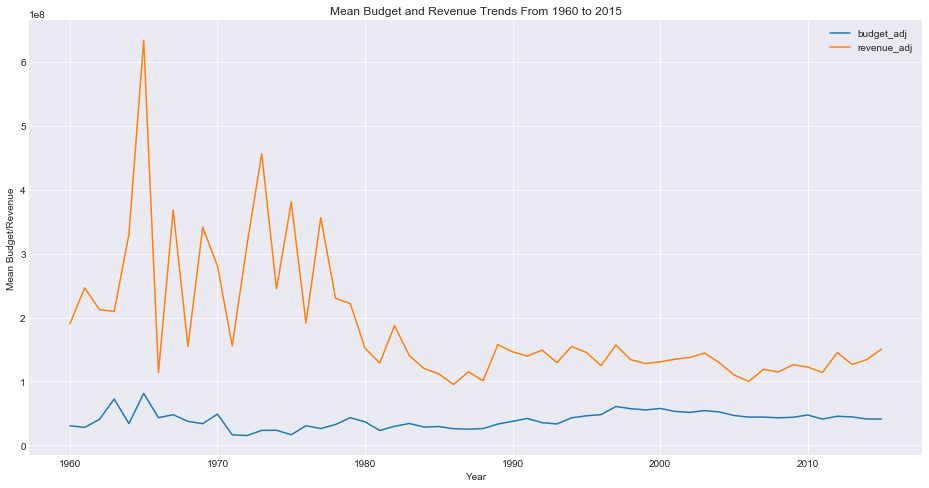

In [19]:
## year-wise trends in mean budgets and reveneus:

# extract mean data:
budgets_grouped_by_year = revenue_df.groupby('release_year', as_index=False)['budget_adj']
revenues_grouped_by_year = revenue_df.groupby('release_year', as_index=False)['revenue_adj']

yearly_budget_means = budgets_grouped_by_year.mean()
yearly_revenue_means = revenues_grouped_by_year.mean()

# now plotting:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.plot(yearly_budget_means['release_year'], yearly_budget_means['budget_adj'])
ax.plot(yearly_revenue_means['release_year'], yearly_revenue_means['revenue_adj'])
plt.xlabel('Year')
plt.ylabel('Mean Budget/Revenue')
plt.title('Mean Budget and Revenue Trends From 1960 to 2015')
plt.legend()
plt.show()

It's interesting to note that the budgets and revenues haven't increased or decreased significantly over the years. Also, variation in the means has steadily gone down. This might be due to higher number of movies produced nowadays.

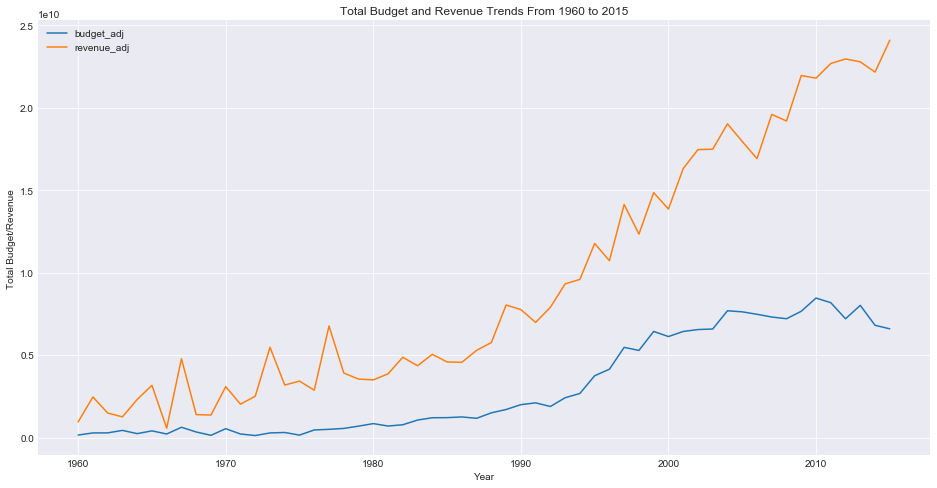

In [20]:
## year-wise trends in total budgets and reveneus for all movies:

# extract sums:
yearly_budget_sums = budgets_grouped_by_year.sum()
yearly_revenue_sums = revenues_grouped_by_year.sum()

# now plotting:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.plot(yearly_budget_sums['release_year'], yearly_budget_sums['budget_adj'])
ax.plot(yearly_revenue_sums['release_year'], yearly_revenue_sums['revenue_adj'])
plt.xlabel('Year')
plt.ylabel('Total Budget/Revenue')
plt.title('Total Budget and Revenue Trends From 1960 to 2015')
plt.legend()
plt.show()

Quite as expected, both the total budget and revenue gained have been increasing steadily over the years. The film industry has grown a lot since the 1960's.

### Characteristics Of Movies With High Revenues

Let's look at the different variables that may affect the revenue collected by a movie. 

#### Budget

First, let's create a scatter-plot to visualize the relationship between budget and movie revenue.

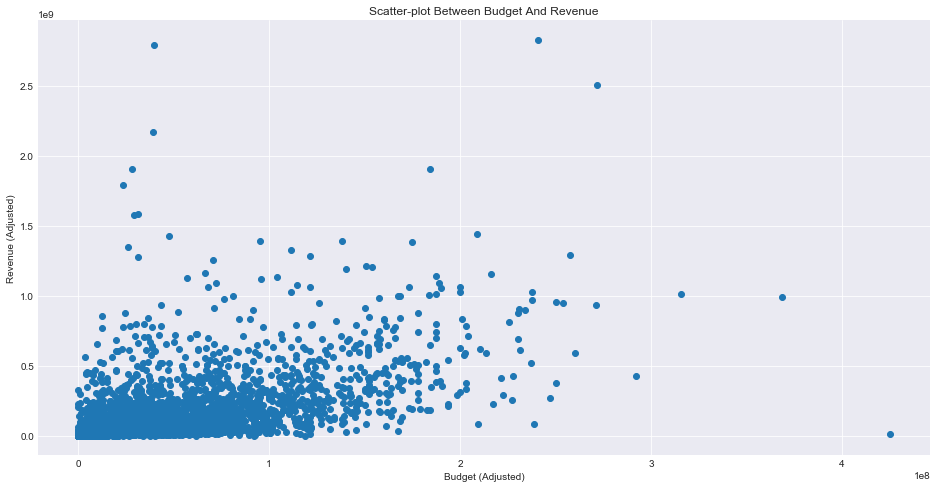

In [21]:
# using matplotlib's scatter() function:

fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.scatter(revenue_df['budget_adj'], revenue_df['revenue_adj'])
plt.xlabel('Budget (Adjusted)')
plt.ylabel('Revenue (Adjusted)')
plt.title('Scatter-plot Between Budget And Revenue')
plt.show()

There appears to be a moderate positive correlation. Let's calculate the correlation coefficient.

In [22]:
# using DataFrame.corr() function and the Pearson method to calculate correlation:
correlations = revenue_df.corr() # returns a dataframe containing pairwise correlation values

print('Correlation(Budget/Revenue):', correlations.loc['budget_adj', 'revenue_adj'])
print('Coefficient of Determination(r-squared):', correlations.loc['budget_adj', 'revenue_adj']**2)

Correlation(Budget/Revenue): 0.5704510195812392
Coefficient of Determination(r-squared): 0.32541436574127536


According to the coefficient of determination, approximately 32.54% of the variation in the revenue is explained by the variation in budgets.

#### Popularity

Again, let's create a scatter plot first.

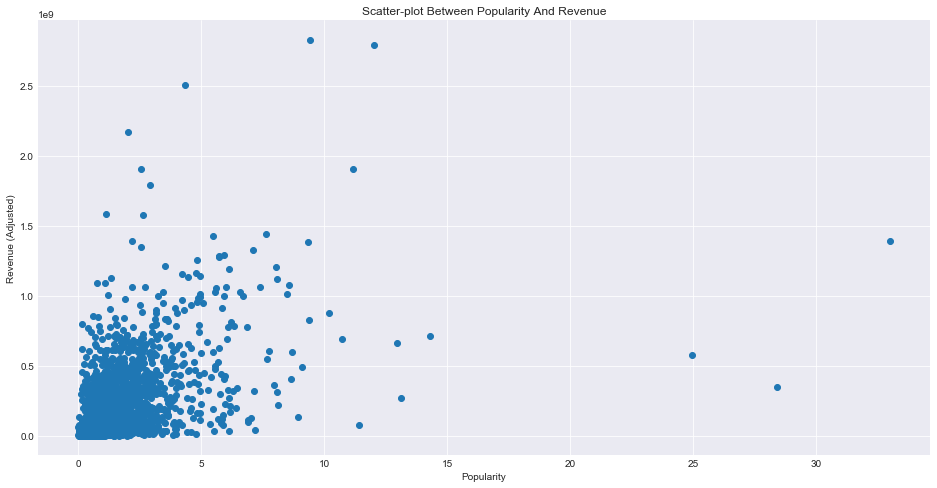

In [23]:
# using matplotlib's scatter() function:

fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.scatter(revenue_df['popularity'], revenue_df['revenue_adj'])
plt.xlabel('Popularity')
plt.ylabel('Revenue (Adjusted)')
plt.title('Scatter-plot Between Popularity And Revenue')
plt.show()

There seems to be a moderate positive correlation between popularity and revenue. Let's look at the correlation coefficient.

In [24]:
print('Correlation(Popularity/Revenue):', correlations.loc['popularity', 'revenue_adj'])
print('Coefficient of Determination(r-squared):', correlations.loc['popularity', 'revenue_adj']**2)

Correlation(Popularity/Revenue): 0.5469591846171393
Coefficient of Determination(r-squared): 0.2991643496370459


Approximately 29.9% of the variation in revenue is explained by the variation in popularity.

#### Cast

Let's take a look at the histogram for all revenues.

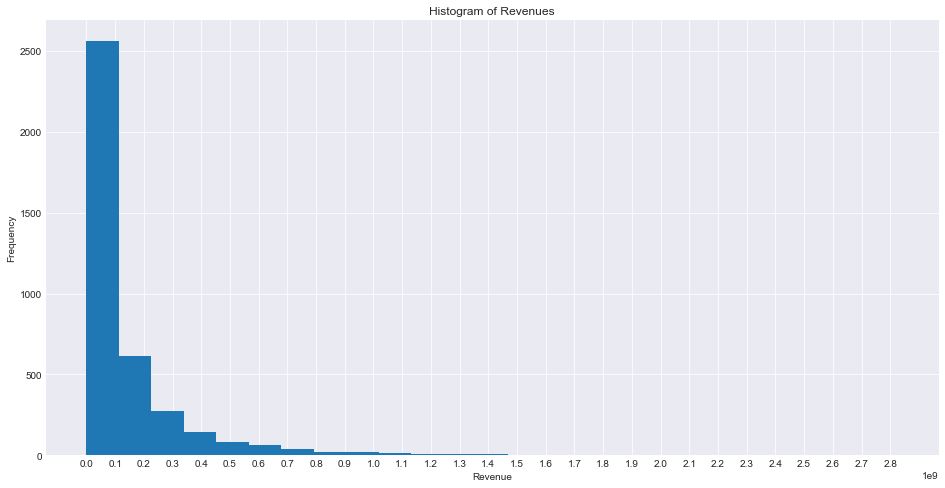

Revenue Statistics:


count    3.854000e+03
mean     1.370647e+08
std      2.161114e+08
min      2.370705e+00
25%      1.835735e+07
50%      6.173068e+07
75%      1.632577e+08
max      2.827124e+09
Name: revenue_adj, dtype: float64

In [25]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
ax.hist(revenue_df['revenue_adj'], bins=25)
plt.xticks(np.arange(0, revenue_df['revenue_adj'].max()+1, 0.1e9)) # setting a higher frequency for ticks on x axis
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Revenues')
plt.show()

# let's take a look at some statistics as well:
print('Revenue Statistics:')
revenue_df['revenue_adj'].describe()

Most movies have revenues less than 200 million dollars. So exactly what threshold revenue should be set for a movie to be said to have "high-revenue"? I will set the following definition:

__High revenue:__ Revenue higher than 70% of the movies.

Of course, this definition cannot be proven to be right or wrong. But I think that 70% is a reasonable percentile value.

Let's calculate the threshold revenue.

In [26]:
# using pandas' built-in function, quantile()
threshold_revenue = revenue_df['revenue_adj'].quantile(0.7) 

print('Threshold revenue:', threshold_revenue)

Threshold revenue: 132085473.38714704


About 133 million dollars. That is reasonably high revenue.

_Returning to the question of the cast's correlation with movie revenue_, in order to determine the actors correlating to high revenues, I will find the top 20 actors who have acted in most high-revenue movies.

First let's create a dataframe with only high-revenue movies.

In [27]:
high_revenue_movies = revenue_df[revenue_df['revenue_adj'] >= threshold_revenue]

print('Number of high-revenue movies:', len(high_revenue_movies))
high_revenue_movies.head()

Number of high-revenue movies: 1156


,id,popularity,original_title,cast,director,runtime,genres,production_companies,release_date,vote_average,release_year,budget_adj,revenue_adj
0,135397,32.985763,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",Colin Trevorrow,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",2015-06-09,6.5,2015,1.379999e+08,1.392446e+09
1,76341,28.419936,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",George Miller,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",2015-05-13,7.1,2015,1.379999e+08,3.481613e+08
2,262500,13.112507,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",Robert Schwentke,119,"[Adventure, Science Fiction, Thriller]","[Summit Entertainment, Mandeville Films, Red W...",2015-03-18,6.3,2015,1.012000e+08,2.716190e+08
3,140607,11.173104,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",J.J. Abrams,136,"[Action, Adventure, Science Fiction, Fantasy]","[Lucasfilm, Truenorth Productions, Bad Robot]",2015-12-15,7.5,2015,1.839999e+08,1.902723e+09
4,168259,9.335014,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",James Wan,137,"[Action, Crime, Thriller]","[Universal Pictures, Original Film, Media Righ...",2015-04-01,7.3,2015,1.747999e+08,1.385749e+09


In [28]:
# We should have a function to aggregate list data from a column and return counts for unique members.
# This function will also be useful next analyses regarding genres and production companies

def aggregate_list_column(df, column):
    # aggregate all lists into a single pandas series:
    list_sum = pd.Series(df[column][df[column].notna()].sum())
    
    # converting data to counts of unique elements, in descending order and return:
    counts = list_sum.value_counts(ascending=False)
    return counts
                                   
counts = aggregate_list_column(high_revenue_movies, 'cast')
print('Total number of actors:', len(counts))

# display the top twenty actors:
print('\nThe top 20:\n')
pprint(counts.head(20))

Total number of actors: 2661

The top 20:

Tom Cruise               27
Brad Pitt                22
Tom Hanks                21
Eddie Murphy             20
Robert De Niro           20
Sylvester Stallone       19
Harrison Ford            19
Bruce Willis             19
Adam Sandler             18
Jim Carrey               18
Ben Stiller              17
Cameron Diaz             17
Denzel Washington        17
Will Smith               17
Samuel L. Jackson        17
Arnold Schwarzenegger    17
Mel Gibson               16
Robin Williams           16
Julia Roberts            15
Nicolas Cage             15
dtype: int64


Tom Cruise comes out on top! He also seems to have quite a lead. We also see other famous names like Brad Pitt, Tom Hanks, Sylvester Stallone, Arnold Schwarzenegger and Jim Carrey.

#### Genres

We'll follow the same procedure as that for cast and find out the top 5 genres that are present in most high-revenue movies.

In [29]:
counts = aggregate_list_column(high_revenue_movies, 'genres')
print('Total number of genres:', len(counts))

# display the top 5 genres:
print('\nThe top 5:\n')
pprint(counts.head(5))

Total number of genres: 18

The top 5:

Action       458
Drama        405
Comedy       400
Adventure    392
Thriller     346
dtype: int64


This result doesn't surprise me. The big blockbusters always seem to have these genres.

#### Production Companies

Let's list the top 10 production companies.

In [30]:
counts = aggregate_list_column(high_revenue_movies, 'production_companies')
print('Total number of production companies:', len(counts))

# display the top 10 production companies:
print('\nThe top 10:\n')
pprint(counts.head(10))

Total number of production companies: 1010

The top 10:

Universal Pictures                        148
Warner Bros.                              146
Paramount Pictures                        135
Twentieth Century Fox Film Corporation    114
Columbia Pictures                          81
Walt Disney Pictures                       72
New Line Cinema                            49
Columbia Pictures Corporation              47
DreamWorks SKG                             41
Touchstone Pictures                        40
dtype: int64


These are the most famous production companies. And now I know the reason.

#### Director

Let's find out the top 5 directors.

In [31]:
top_directors_data = pd.Series(high_revenue_movies['director']).dropna()
counts = top_directors_data.value_counts(ascending=False)

print('Total number of directors:', len(counts))

# display the top 5 directors:
print('\nThe top 5:\n')
pprint(counts.head(5))

Total number of directors: 555

The top 5:

Steven Spielberg    23
Robert Zemeckis     13
Tim Burton          11
Ridley Scott        10
Michael Bay         10
Name: director, dtype: int64


Steven Spielberg is way ahead with 23 movies. He is considered one of the best directors, if not the best, in the history of Hollywood.

#### Month and Weekday

Let's get the number of high-revenue movies for each month and for each weekday.

In [32]:
# get series for months and weekdays:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def getmonth(datetime_obj):
    if not isinstance(datetime_obj, float):
        return months[datetime_obj.month-1]
    return np.nan

def getweekday(datetime_obj):
    if not isinstance(datetime_obj, float):
        return weekdays[datetime_obj.weekday()]
    return np.nan

month_series = high_revenue_movies['release_date'].apply(getmonth)
weekday_series = high_revenue_movies['release_date'].apply(getweekday)

# get counts of high movies for each month and weekday:
month_counts = month_series.value_counts(ascending=False)
weekday_counts = weekday_series.value_counts(ascending=False)

# rearrange the series' indexes in temporal order:
month_counts = month_counts[months]
weekday_counts = weekday_counts[weekdays]

Now let's plot some bar graphs to visualize these counts.

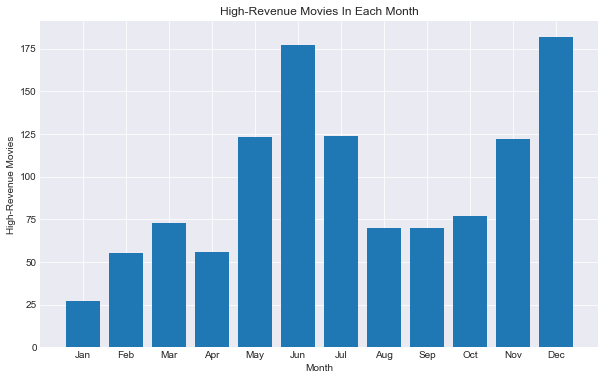

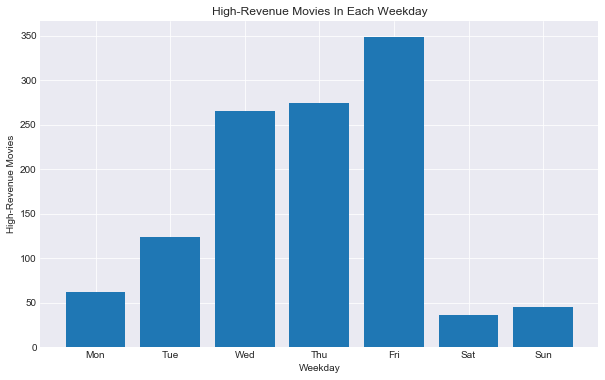

In [33]:
# plot bar graphs to visualize the data:
 # for months:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.bar(month_counts.index, month_counts)
plt.xlabel('Month')
plt.ylabel('High-Revenue Movies')
plt.title('High-Revenue Movies In Each Month')
plt.show()

 # for weekdays:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.bar(weekday_counts.index, weekday_counts)
plt.xlabel('Weekday')
plt.ylabel('High-Revenue Movies')
plt.title('High-Revenue Movies In Each Weekday')
plt.show()

In the month plot we get peeks in the months of June and Dec. These might be explained by the fact that a lot of people are on summer or winter vacations. So this kind of pattern for months is expected. On the other hand, for weekdays, we get the lowest number of high-revenue movies on weekends. Although it would be wrong to expect any pattern for weekdays because revenue collection is spread out over months, this is still kind of unexpected and goes to show that the weekday of release might not correlate much to the revenue.

Let's take a look at the average revenue for each month and weekday.

In [34]:
# first we need to add month and weekday columns in order to group them
revenue_df = revenue_df.assign(release_month=revenue_df['release_date'].apply(getmonth))
revenue_df = revenue_df.assign(release_weekday=revenue_df['release_date'].apply(getweekday))
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3854 entries, 0 to 10848
Data columns (total 15 columns):
id                      3854 non-null int64
popularity              3854 non-null float64
original_title          3854 non-null object
cast                    3850 non-null object
director                3853 non-null object
runtime                 3854 non-null int64
genres                  3854 non-null object
production_companies    3808 non-null object
release_date            3854 non-null datetime64[ns]
vote_average            3854 non-null float64
release_year            3854 non-null int64
budget_adj              3854 non-null float64
revenue_adj             3854 non-null float64
release_month           3854 non-null object
release_weekday         3854 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 481.8+ KB


Two new rows have been added as shown above.

In [35]:
# next let's use groupby() to find mean revenues for each month and weekday:
month_group = revenue_df.groupby('release_month')['revenue_adj']
weekday_group = revenue_df.groupby('release_weekday')['revenue_adj']

# calculate the means:
mean_revenue_by_month = month_group.mean()
mean_revenue_by_weekday = weekday_group.mean()

# rearrange by temporal order:
mean_revenue_by_month = mean_revenue_by_month[months]
mean_revenue_by_weekday = mean_revenue_by_weekday[weekdays]

Let's make plots to visualize the mean revenues for each month and weekday:

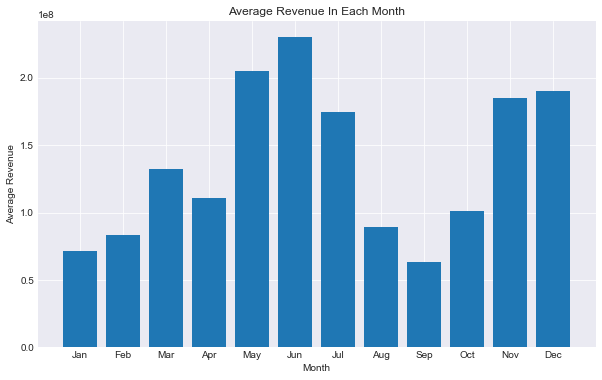

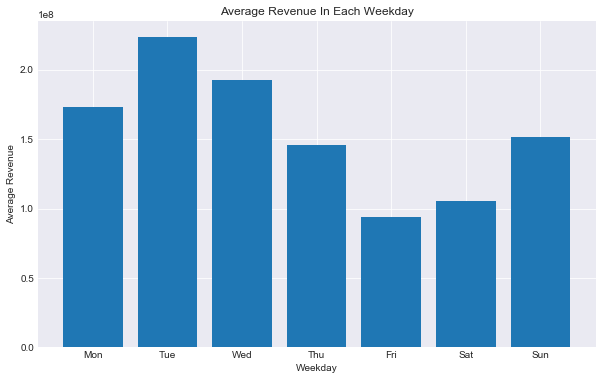

In [36]:
# plot bar graphs to visualize the data:
 # for months:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.bar(mean_revenue_by_month.index, mean_revenue_by_month)
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.title('Average Revenue In Each Month')
plt.show()

 # for weekdays:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.bar(mean_revenue_by_weekday.index, mean_revenue_by_weekday)
plt.xlabel('Weekday')
plt.ylabel('Average Revenue')
plt.title('Average Revenue In Each Weekday')
plt.show()

The pattern for months is reinforced by the plot here. June and Dec and months close to them are the best months for releasing a movie. On the other hand, the plot for weekdays reinforces the idea that weekdays don't correlate much to movie revenue as we see a rather different pattern here.

<a id='conclusions'></a>
## Conclusions

### Research question 1: Trends in budgets and revenues over the years

The plots and statistcs show clearly that the movie industry has grown manifold since the 1960's and if things keep going as they are now, the movie industry will grow even more.

### Research question 2: Characteristics of movies with high revenues

Based on my analysis, if I were asked to predict which movies from a bunch of upcoming ones will have high revenues, I would look for the following characteristics to find out the movies that will have high revenues:

* __High Budget__: The positive correlation shown by my analysis means that a movie with a high budget will have a good chance of getting a high revenue, even though it is not entirely necessary.
* __High Popularity__: Popularity also has a positive correlation with revenue. So I would single out movies with high popularity.
* __Cast__: I would look for movies that have the top actors from my analysis like Tom Cruise, Brad Pitt,Tom Hanks, Eddie Murphy, Robert De Niro, Sylvester Stallone etc. 
* __Genres__: I would consider movies with Action, Drama, Comedy, Adventure and Thriller genres.
* __Production Companies__: I would look for movies from Universal Studios, Paramount Pictures, Warner Bros. Twentieth Century Fox and other top production companies from my analysis.
* __Director__: I would look for movies directed by Steven Spielberg, Michael Bay, Ridley Scott and other top directors.
* __Month of Release__: I would look for movies being release in June and December. My analysis shows that these two months correlate most with high revenues.

I would select those movies that have these characteristics and predict them to have high revenues.

__Limitations:__ I would like to clearly acknowledge the non-concrete nature of my analysis as most of the results have not been proven to be statistically significant and are only tentative. My results are limited because of the following:
* While cleaning the data, I had to remove a lot of movies from the analysis. So the results may only be partially true.
* I have not dealt with any extraneous variables during the course of my analysis. 
* I have not included tests to prove the statistical significance of my results.